# Leios simulation analysis at tag `leios-2025w28`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: 1000 TPS with small transactions and no IBS

In [2]:
label <- "Rust simulator, mini-mainnet, full-without-ibs, 300 B/tx, 1000 tx/s, 5 slot/stage, 2.5 EB/stage"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
lifecycle <- fread("results/quick/lifecycle.csv.gz", stringsAsFactors=TRUE)
lifecycle[, `Kind`:=factor(`Kind`, levels=c("RB", "EB", "IB", "TX"))]
lifecycle %>% summary

 Simulator                 Variant            Sharding      Kind       
 Rust:310130   full-without-ibs:310130   unsharded:310130   RB:    53  
                                                            EB:   450  
                                                            IB:     0  
                                                            TX:309627  
                                                                       
                                                                       
                                                                       
           Item           Size [B]          References      Created [s]   
 0           :     1   Min.   :   240.0   Min.   :  0.00   Min.   : 17.0  
 1           :     1   1st Qu.:   300.0   1st Qu.:  1.00   1st Qu.:135.1  
 10          :     1   Median :   300.0   Median :  3.00   Median :210.4  
 100         :     1   Mean   :   395.3   Mean   :  2.94   Mean   :210.6  
 100-node-134:     1   3rd Qu.:   300.0   3rd Qu.

In [4]:
vaFactor <- function(ts, decreasing=FALSE) factor(ts)

In [5]:
lifecycle[, `Variant`:=vaFactor(`Variant`, FALSE)]

#### Range of transaction injection

In [6]:
txFirst <- 60
txLast <- 360
txWindow <- txLast - txFirst
simFinish <- 900

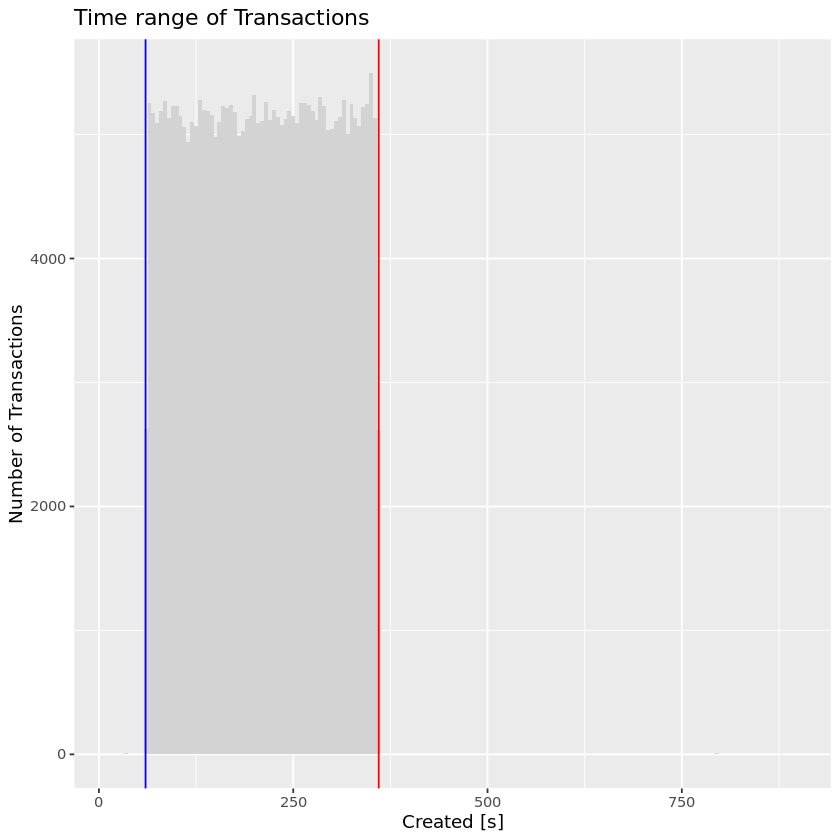

In [7]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [8]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [IB/s]`=sum(`Size [B]`)/txWindow/1024/2048/0.2
    ),
    .(`Variant`)
]

Variant,Demand [tx/s],Demand [MB/s],Demand [IB/s]
<fct>,<dbl>,<dbl>,<dbl>
full-without-ibs,1032.09,0.309627,0.7382083


#### Size of persisted data

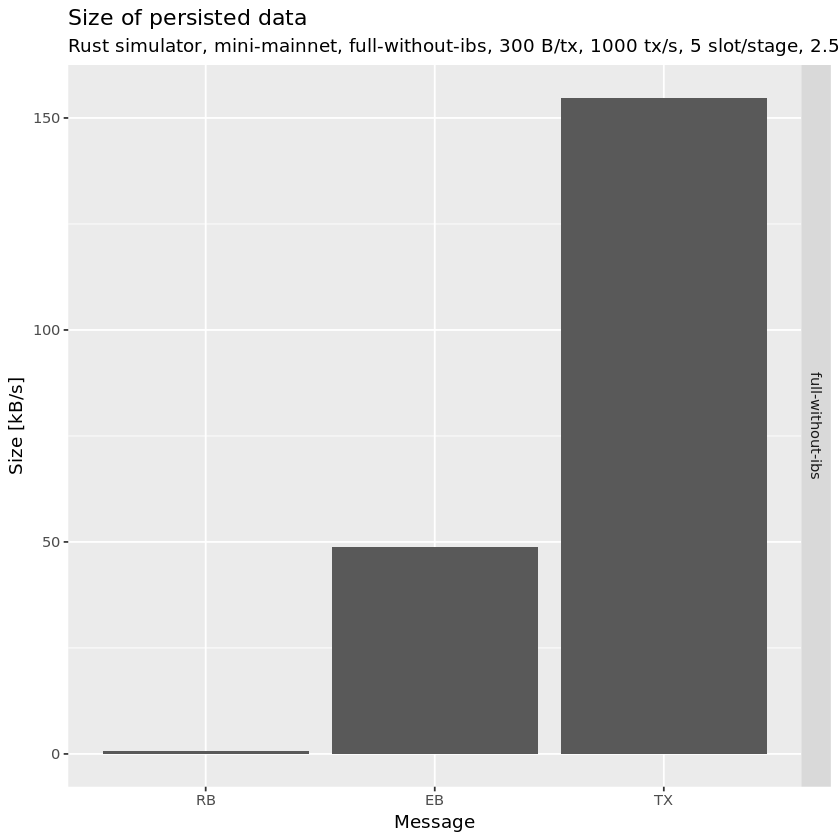

In [9]:
ggplot(
    lifecycle[, .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600), .(`Message`=`Kind`, `Variant`)],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_grid(`Variant` ~ ., scales="free") +
    ggtitle("Size of persisted data", subtitle=label)

In [10]:
ggsave("plots/quick/sizes.png", units="in", dpi=150, width=8, height=6)

In [11]:
ggsave("plots/quick/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

In [12]:
lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Variant`)
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`Variant`)
        ],
        on=c("Variant")
    ][, .(`Variant`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)]

Variant,Space efficiency [%]
<fct>,<dbl>
full-without-ibs,73.79888


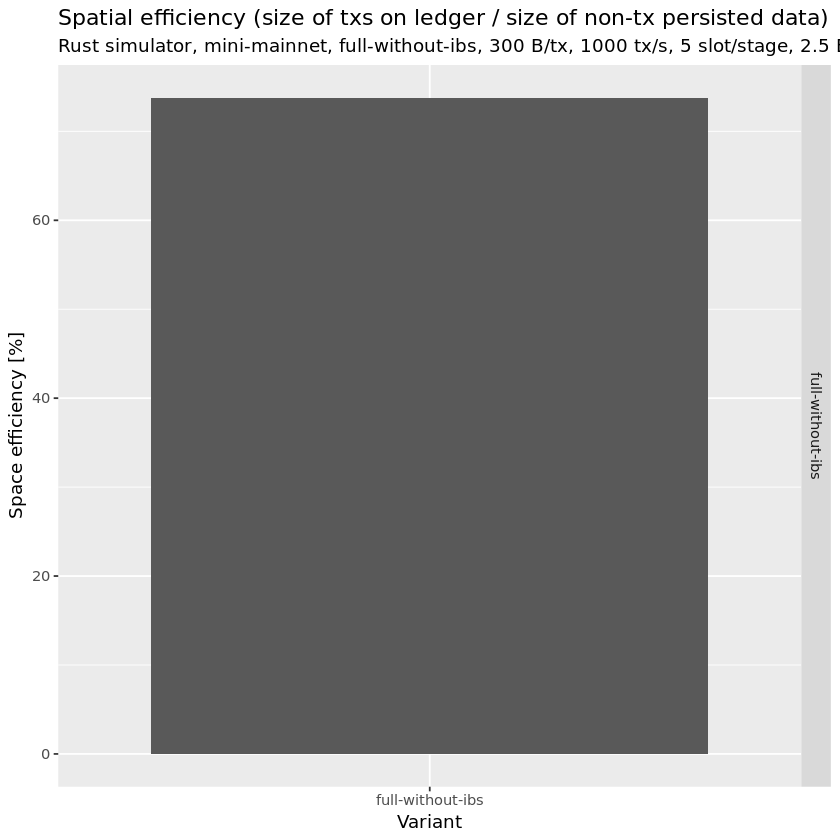

In [13]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Variant`)
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`Variant`)
        ],
        on=c("Variant")
    ][, .(`Variant`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`Variant`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Variant` ~ ., scales="free") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [14]:
ggsave("plots/quick/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [15]:
ggsave("plots/quick/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

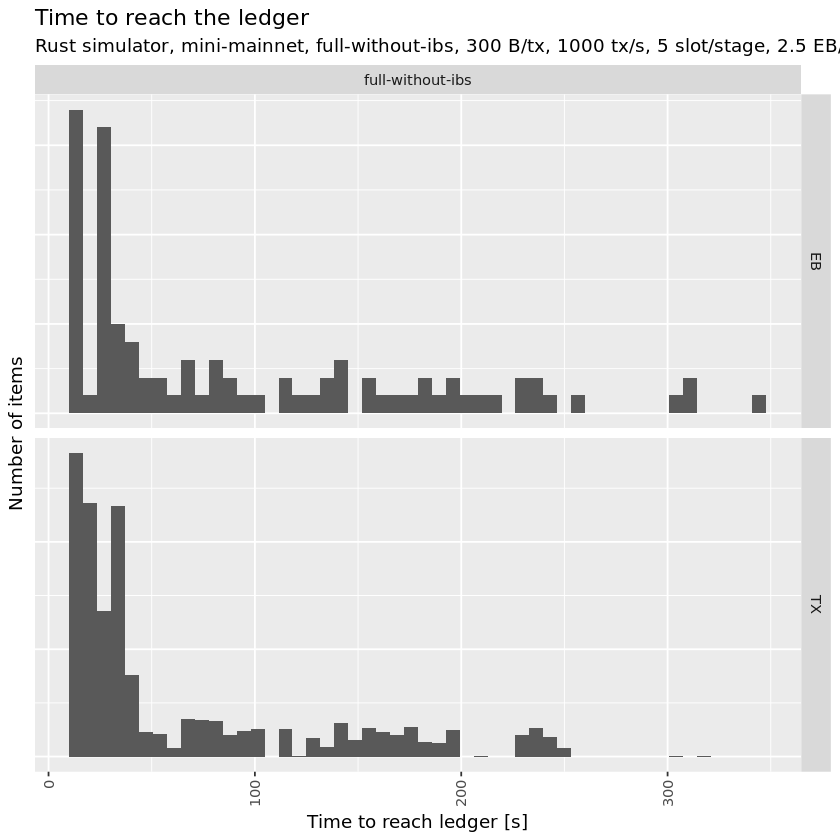

In [16]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB") & 
        !is.na(`To RB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Variant`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_grid(`Kind` ~ `Variant`, scales="free") +
    ylab("Number of items") +
    ggtitle("Time to reach the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [17]:
ggsave("plots/quick/reach-rb.png", units="in", dpi=150, width=8, height=6)

In [18]:
ggsave("plots/quick/reach-rb.svg", units="in", dpi=150, width=8, height=6)

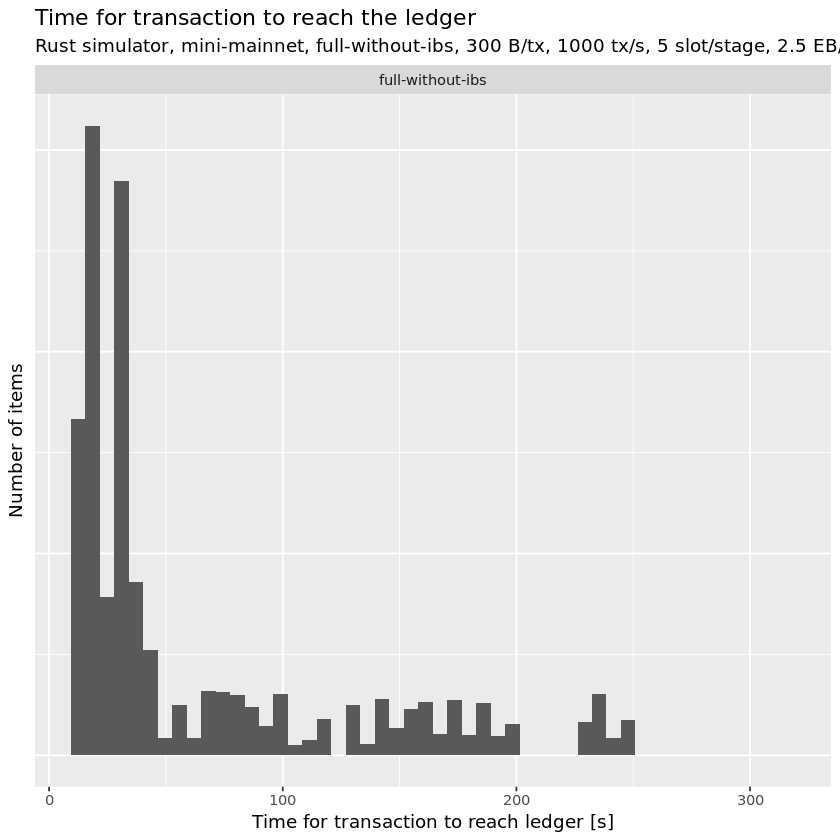

In [19]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Variant`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_grid(. ~ `Variant`, scales="free_y") +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [20]:
ggsave("plots/quick/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [21]:
ggsave("plots/quick/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an EB

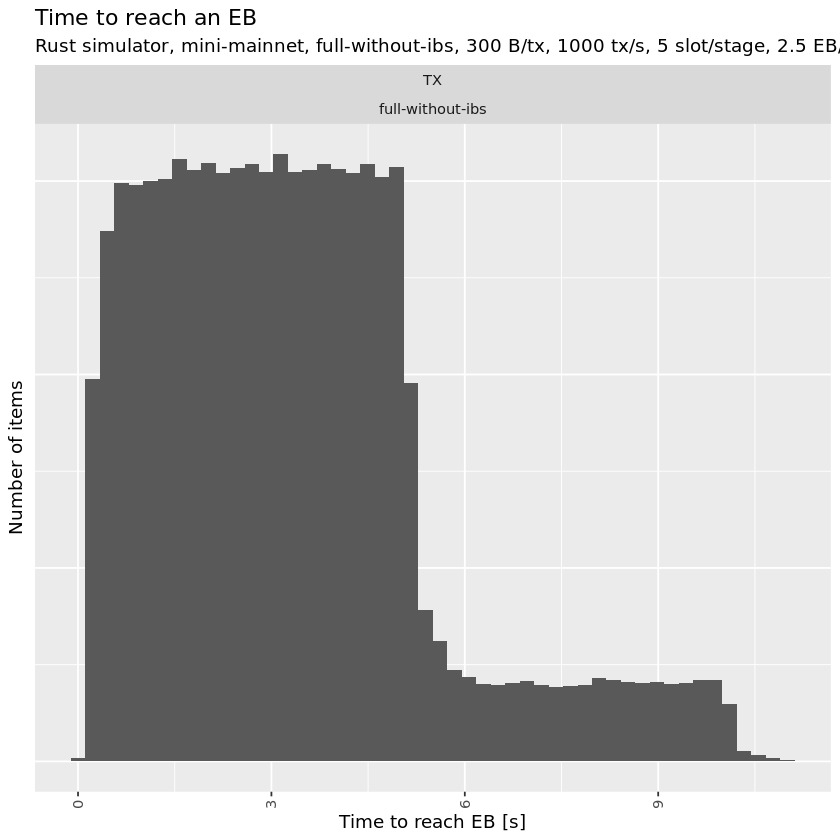

In [22]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB") & 
        !is.na(`To EB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=`To EB [s]`-`Created [s]`), 
        .(`Kind`, `Variant`)
    ],
    aes(x=`Time to reach EB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Variant`, scales="free") +
    ylab("Number of items") +
    ggtitle("Time to reach an EB", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [23]:
ggsave("plots/quick/reach-eb.png", units="in", dpi=150, width=8, height=6)

In [24]:
ggsave("plots/quick/reach-eb.svg", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

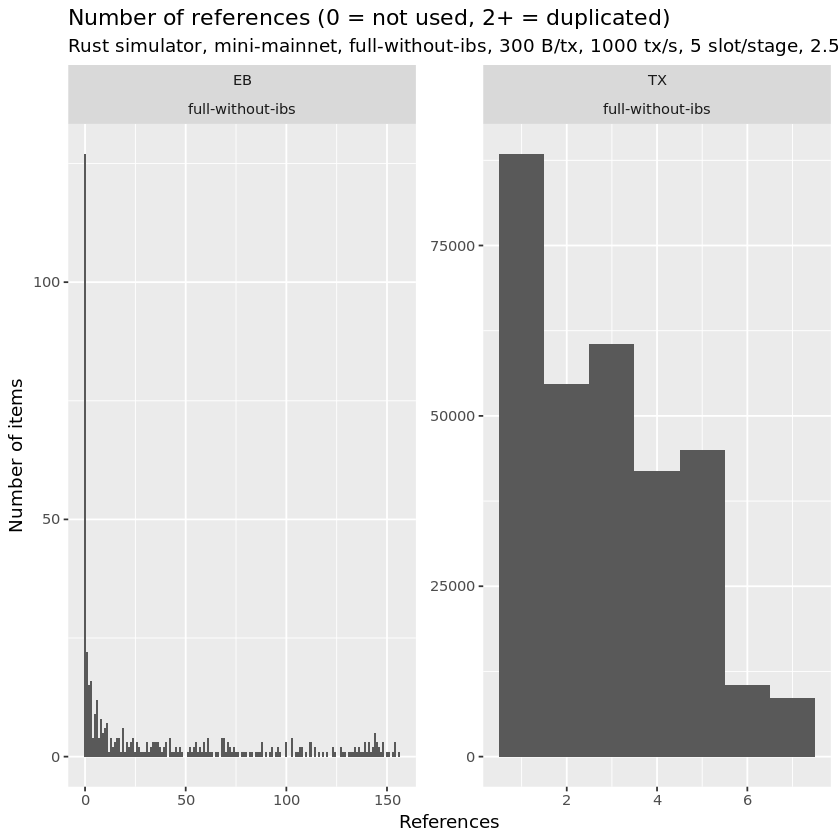

In [25]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB")
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_wrap(`Kind` ~ `Variant`, scales="free") +
    ylab("Number of items") +
    ggtitle("Number of references (0 = not used, 2+ = duplicated)", label)

In [26]:
ggsave("plots/quick/references.png", units="in", dpi=150, width=8, height=6)

In [27]:
ggsave("plots/quick/references.svg", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [28]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        NA
}

In [29]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(ceiling(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Variant`
    )
][order(`Variant`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [30]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Variant`, `Submitted [minute]`)]

#### Transactions reaching the ledger

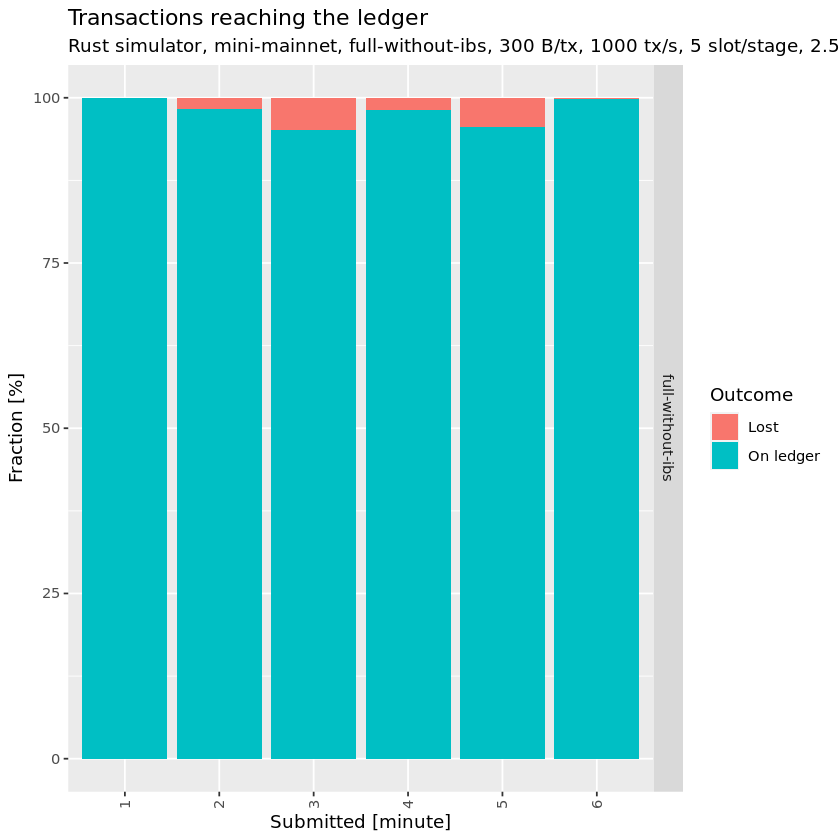

In [31]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Variant`, `Submitted [minute]`)],
        id.vars=c("Variant", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[, .(
        `Variant`, 
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Variant` ~ .) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [32]:
ggsave("plots/quick/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [33]:
ggsave("plots/quick/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

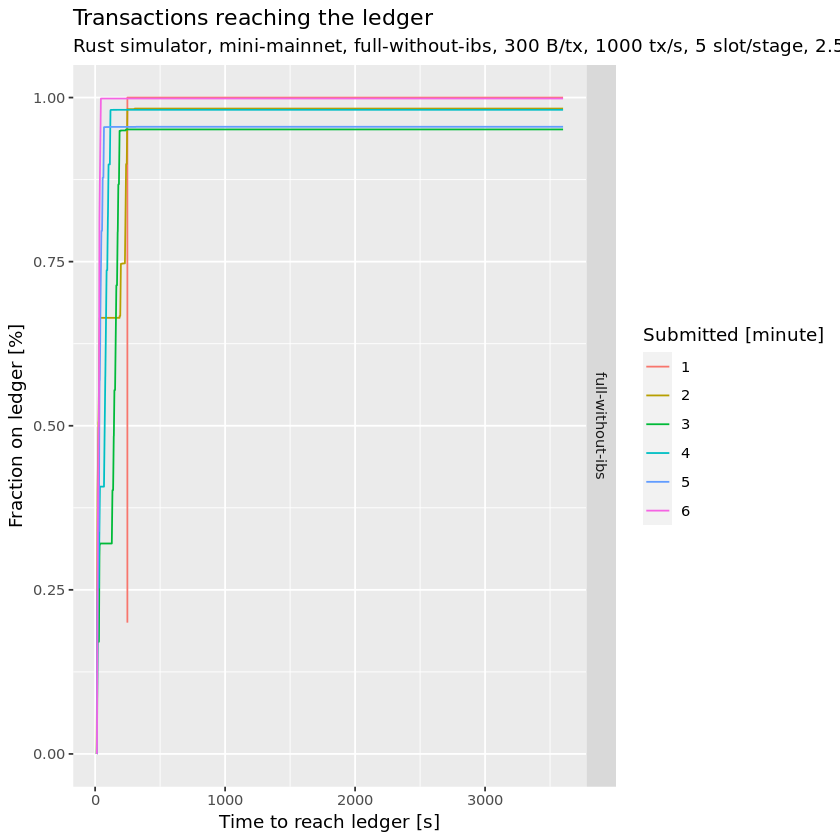

In [34]:
ggplot(
    rbind(
        totals[
            outcomes[!is.na(`Time to reach ledger [s]`), .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), .(`Variant`, `Submitted [minute]`)],
            on=c("Variant", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Variant`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Variant`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 0],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_grid(`Variant` ~ .) +
    ggtitle("Transactions reaching the ledger", label)

In [35]:
ggsave("plots/quick/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [36]:
ggsave("plots/quick/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

#### Release memory

In [37]:
rm(lifecycle, outcomes, totals)

### Resource usage

In [38]:
resources <- fread("results/quick/resources.csv.gz", stringsAsFactors=TRUE)
resources %>% summary

 Simulator              Variant         Sharding         Node    
 Rust:750   full-without-ibs:750   unsharded:750   node-0  :  1  
                                                   node-1  :  1  
                                                   node-10 :  1  
                                                   node-100:  1  
                                                   node-101:  1  
                                                   node-102:  1  
                                                   (Other) :744  
   Egress [B]           Disk [B]      Total CPU [s]    Maximum CPU [s/s]
 Min.   :    74130   Min.   :     0   Min.   : 99.68   Min.   :0.6557   
 1st Qu.:  7143006   1st Qu.:     0   1st Qu.:100.02   1st Qu.:1.2185   
 Median : 67903534   Median :     0   Median :100.20   Median :1.2237   
 Mean   :102209386   Mean   : 39610   Mean   :100.12   Mean   :1.2108   
 3rd Qu.:137617655   3rd Qu.:  1904   3rd Qu.:100.20   3rd Qu.:1.2303   
 Max.   :683711592   Max.   :84268

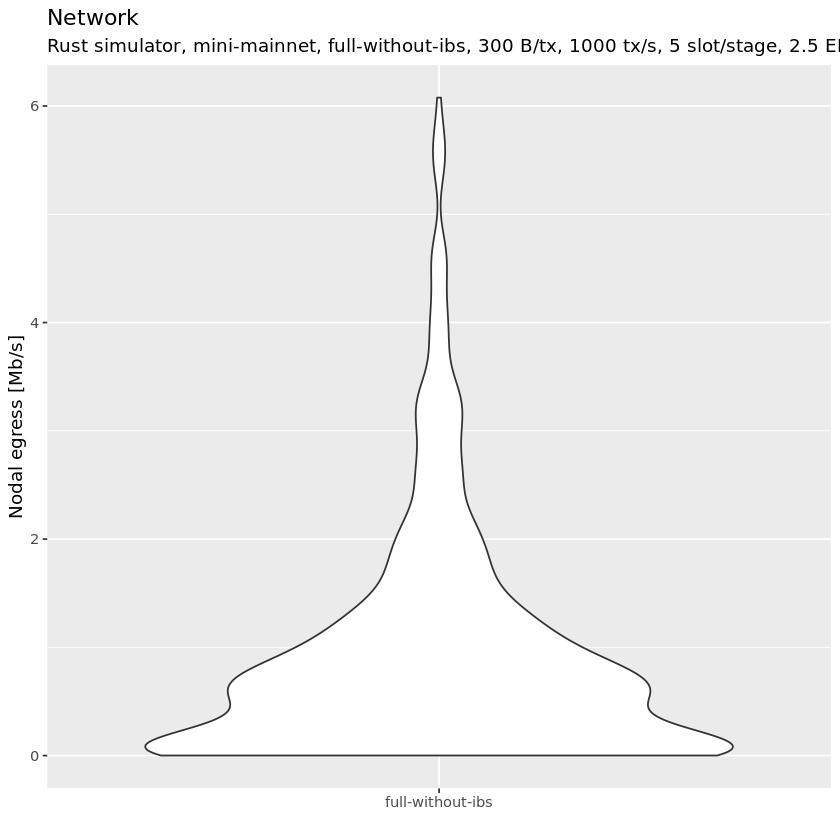

In [39]:
ggplot(
    resources[, .(`Variant`=vaFactor(`Variant`), `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x=`Variant`, y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    xlab("") +
    ggtitle("Network", label)

In [40]:
ggsave("plots/quick/network.png", units="in", dpi=150, width=9.5, height=5.5)

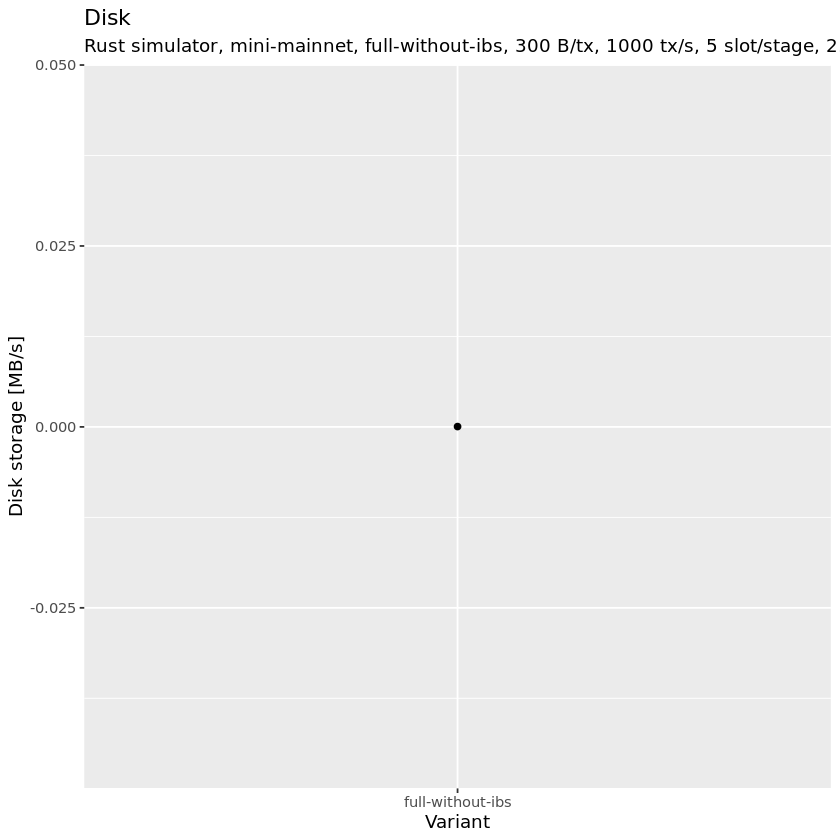

In [41]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Variant`)],
    aes(x=`Variant`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    ggtitle("Disk", label)

In [42]:
ggsave("plots/quick/disk.png", units="in", dpi=150, width=9.5, height=5.5)

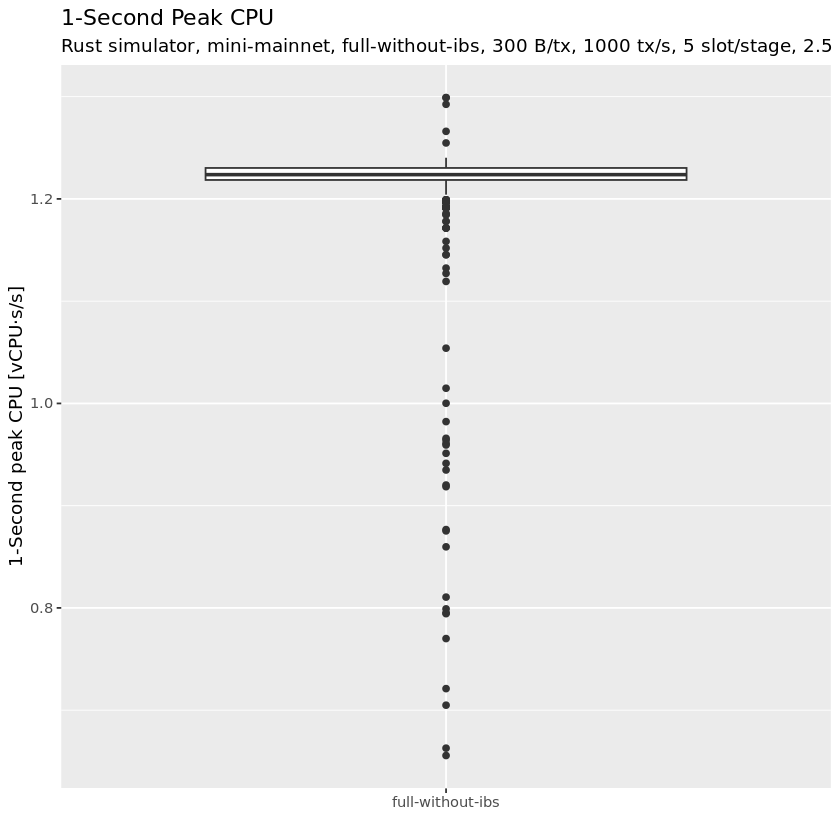

In [43]:
ggplot(
    resources[, .(`Node`, `Variant`=vaFactor(`Variant`), `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`Variant`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
#   ylim(0, NA) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [44]:
ggsave("plots/quick/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

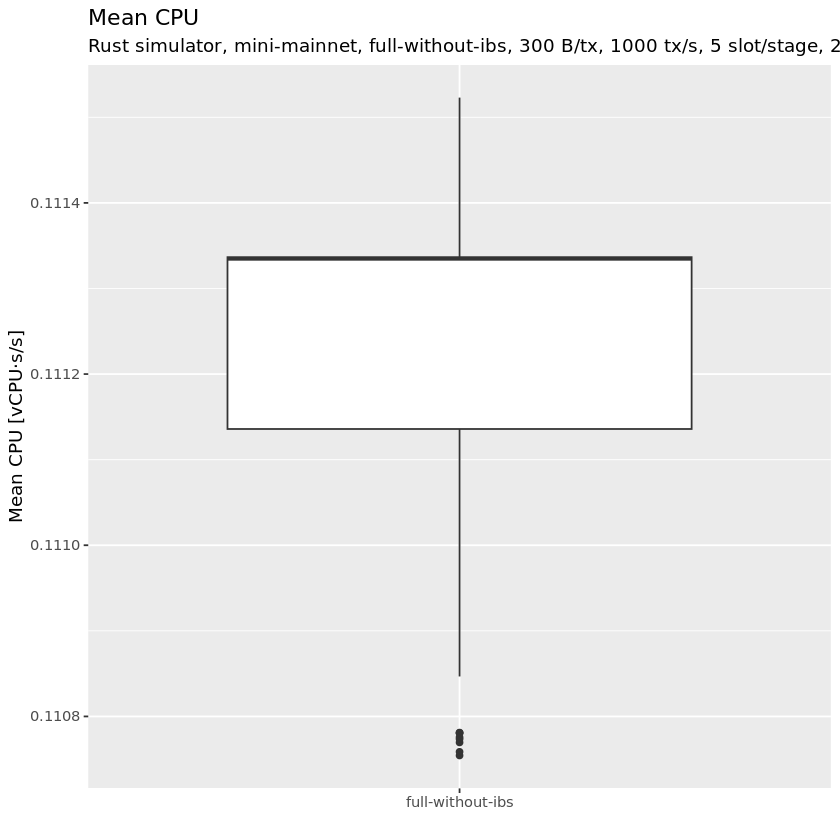

In [45]:
ggplot(
    resources[, .(`Variant`=vaFactor(`Variant`), `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x=`Variant`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
#   ylim(0, NA) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [46]:
ggsave("plots/quick/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [47]:
rm(resources)

### Receipt of messages

#### Read results

In [48]:
receipts <- fread("results/quick/receipts.csv.gz", stringsAsFactors=TRUE)
receipts[, `Variant`:=vaFactor(`Variant`, TRUE)]
receipts %>% summary

 Simulator                    Variant               Sharding        
 Rust:255525614   full-without-ibs:255525614   unsharded:255525614  
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
 Kind                     Item               Producer         Generated [s]  
 EB:   337050   100-node-134:     1498   node-72 :   898800   Min.   : 17.0  
 RB:    39467   110-node-183:     1498   node-363:   483854   1st Qu.:138.9  
 TX:231910623   120-node-167:     1498   node-518:   483854   Median :218.9  
 VT: 23238474   120-node-211:     1498   node-694:   483105   Mean   :233.8  
                120-node-525:     1498   node-443:   48085

In [49]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB RB TX VT
Levels: EB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [50]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Simulator`, `Variant`, `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`Variant` ~ ., scales=scales) +
#       coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

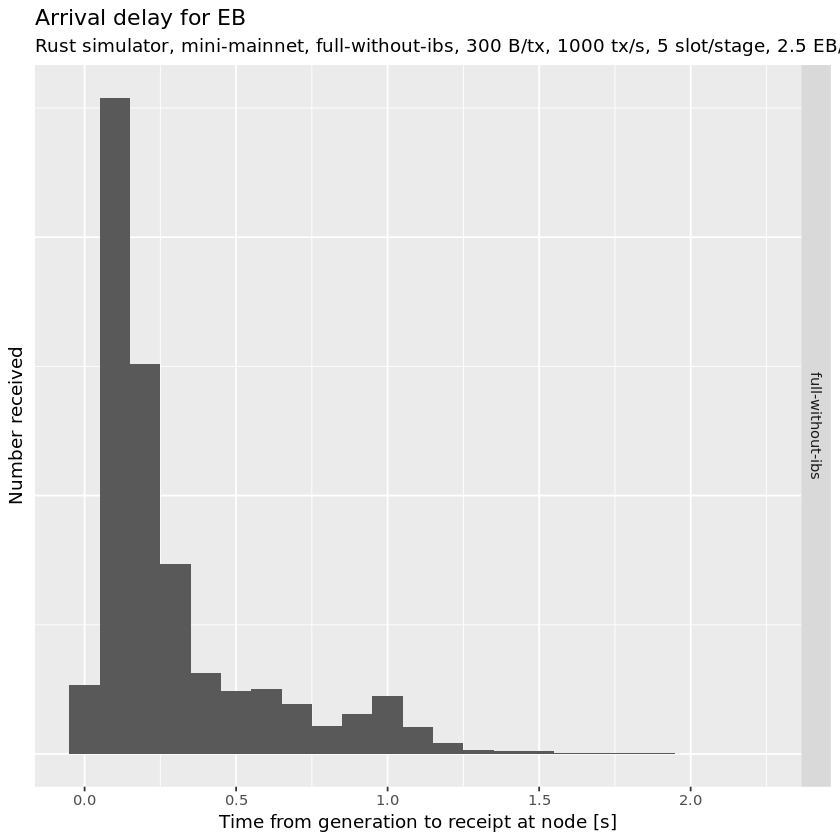

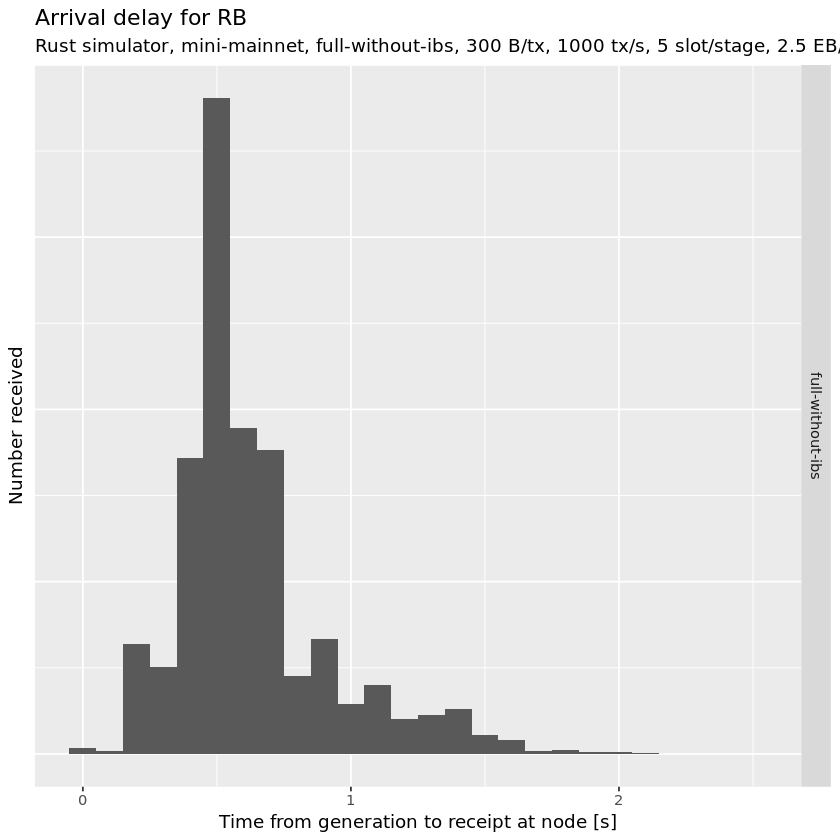

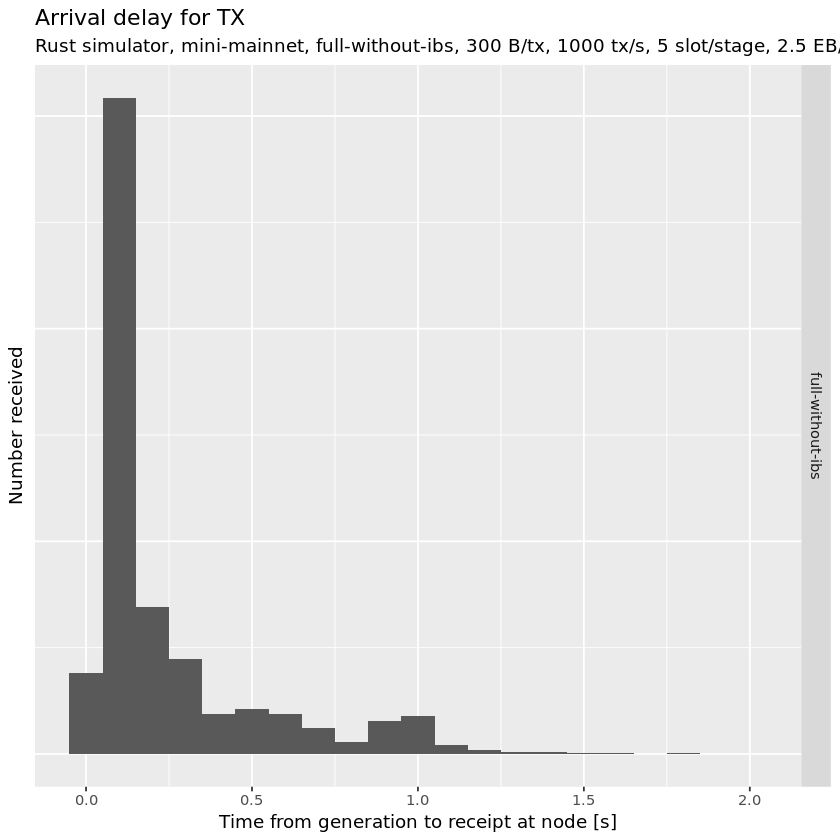

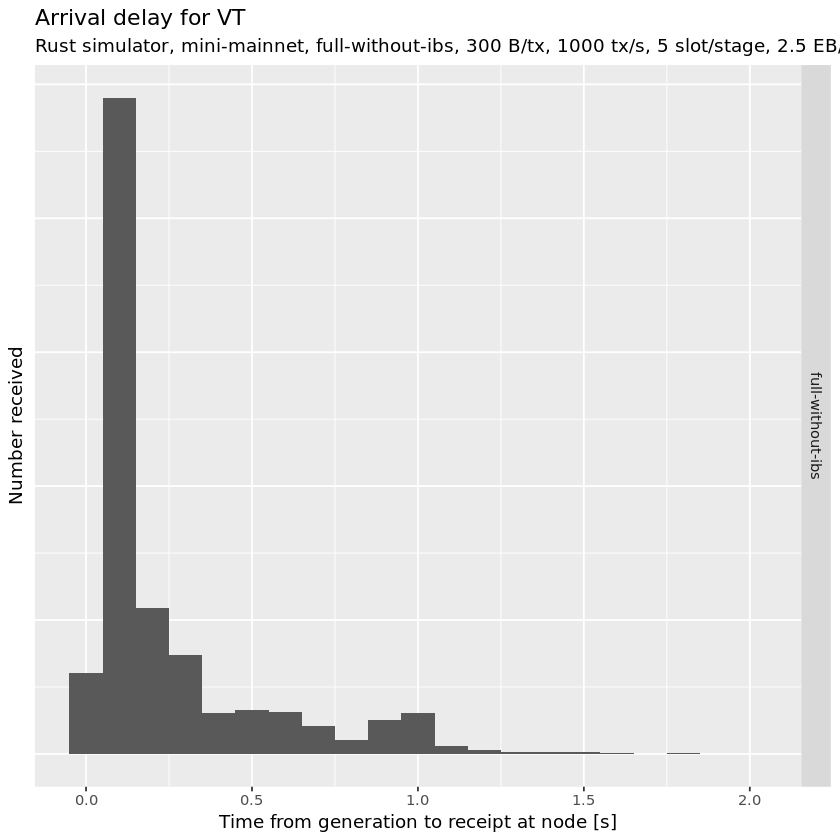

In [51]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/quick/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [52]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)),
            by=.(`Simulator`, `Variant`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`Simulator`, `Variant`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)),
            by=.(`Simulator`, `Variant`, `Generated [s]`)
        ][, .(`Simulator`, `Variant`, `Generated [s]`,`Received`)
        ], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Variant`  ~ ., scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

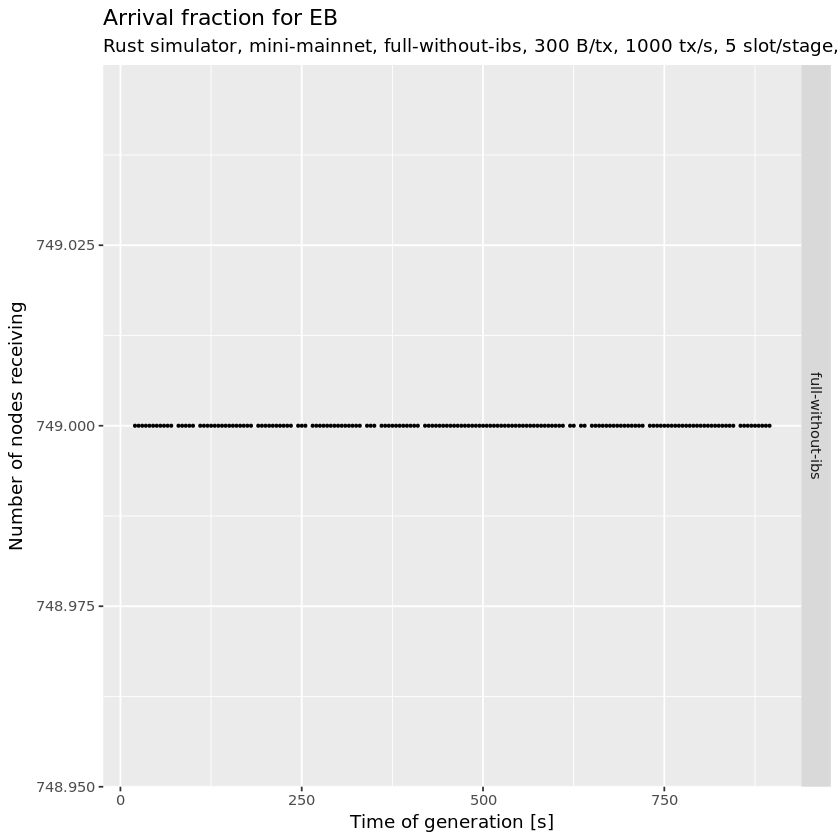

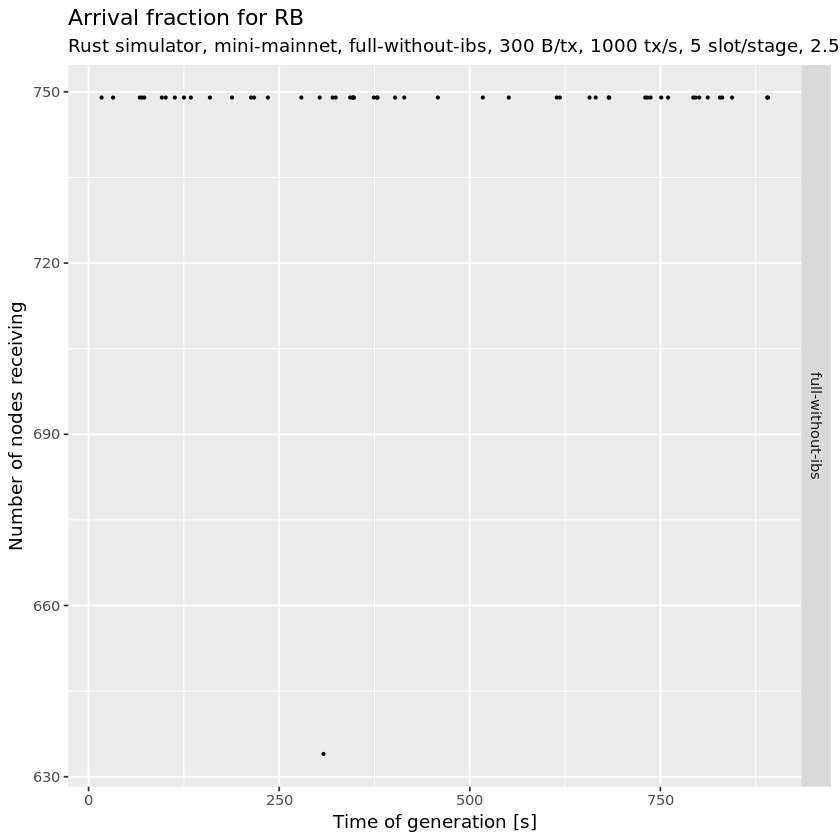

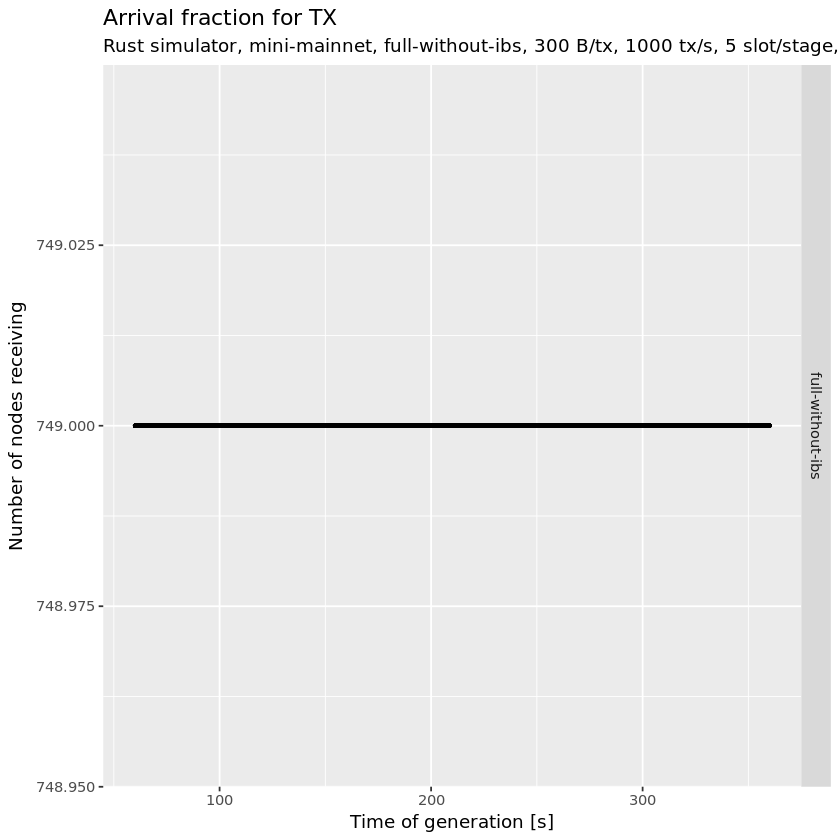

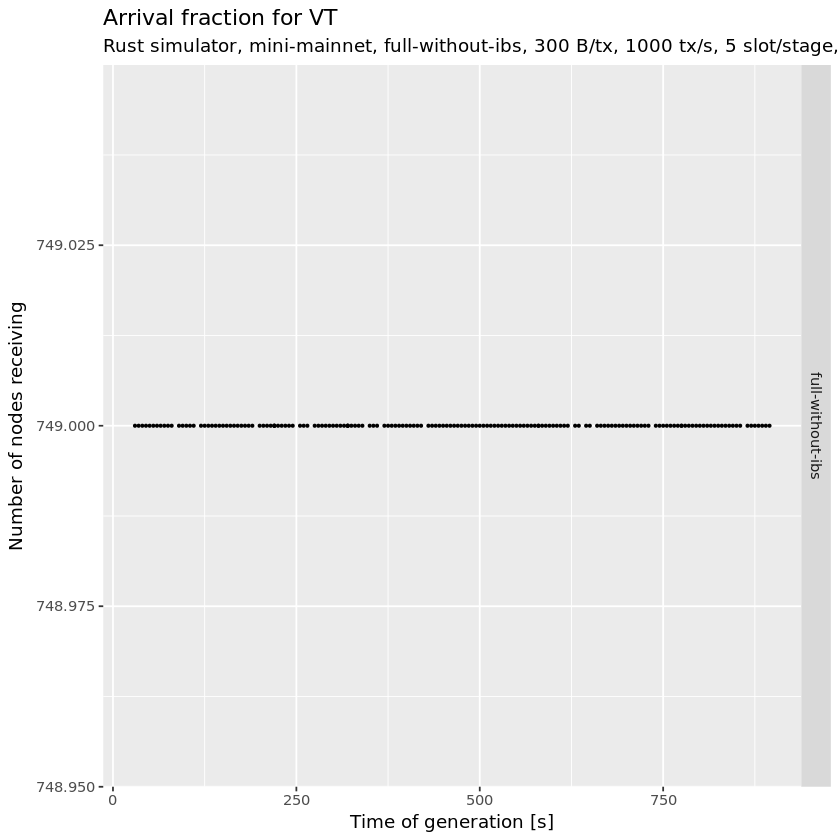

In [53]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/quick/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [54]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9
            ),
            by=.(
                `Simulator`,
                `Variant`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Variant` ~ ., scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

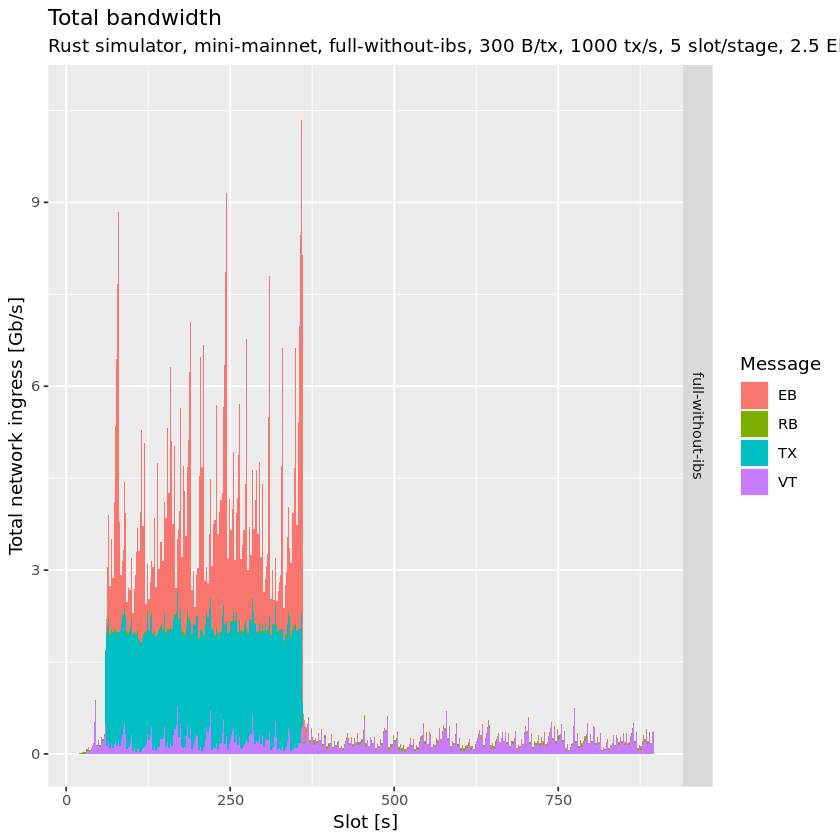

In [55]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/quick/ingress-total-area.png")
)

##### Bandwidth usage per node

In [56]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [57]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount
            ),
            by=.(
                `Simulator`,
                `Variant`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Variant` ~ ., scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

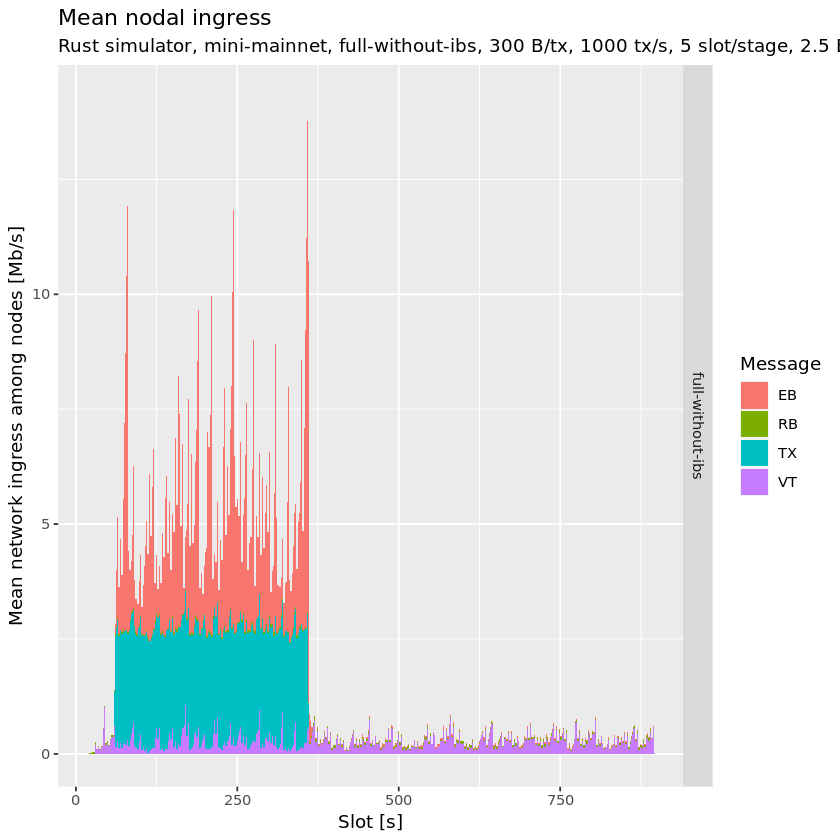

In [58]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/quick/ingress-average-area.png")
)

In [59]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6
            ),
            by=.(
                `Simulator`,
                `Variant`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`,
                `Recipient`
            )
        ][,
            .(`Size [Mb]`=max(`Size [Mb]`)),
            by=.(`Simulator`, `Variant`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Variant` ~ ., scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

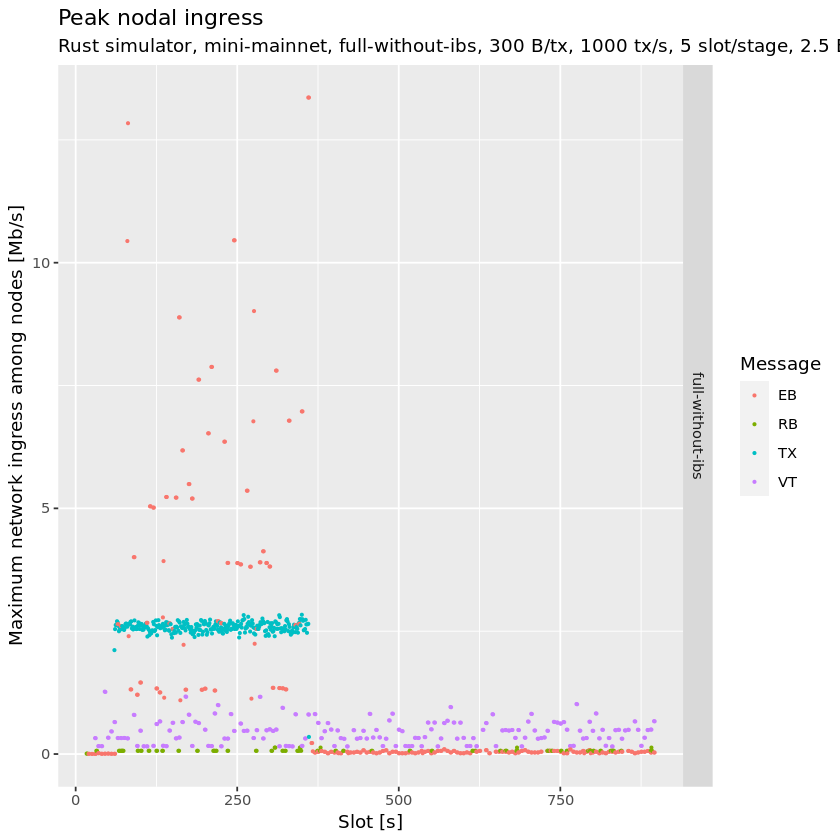

In [60]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/quick/ingress-peak-point.png")
)

#### Release memory

In [61]:
rm(receipts)

### CPU usage

#### Read results

In [62]:
cpus <- fread("results/quick/cpus.csv.gz", stringsAsFactors=TRUE)
cpus[, `Variant`:=vaFactor(`Variant`, TRUE)]
cpus %>% summary

 Simulator                    Variant               Sharding        
 Rust:296811109   full-without-ibs:296811109   unsharded:296811109  
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
      Slot             Node                Task            Duration [s]     
 Min.   : 17.0   node-218:   396164   GenEB  :      452   Min.   :0.000065  
 1st Qu.:146.0   node-139:   396163   GenRB  :       53   1st Qu.:0.000065  
 Median :232.0   node-14 :   396163   GenVote:    86245   Median :0.000065  
 Mean   :265.6   node-140:   396163   ValEB  :   337050   Mean   :0.000253  
 3rd Qu.:319.0   node-143:   396163   ValRB  :    39467   3rd Q

In [63]:
cpusNode <-
cpus[
    ,
    .(`Duration [s]`=sum(`Duration [s]`)),
    by=.(`Simulator`, `Variant`, `Node`, `Slot`)
]

#### Peak CPU usage

##### Histogram

In [64]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*max(`Duration [s]`)),
            by=.(`Simulator`, `Variant`, `Slot`)
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Variant` ~ ., scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

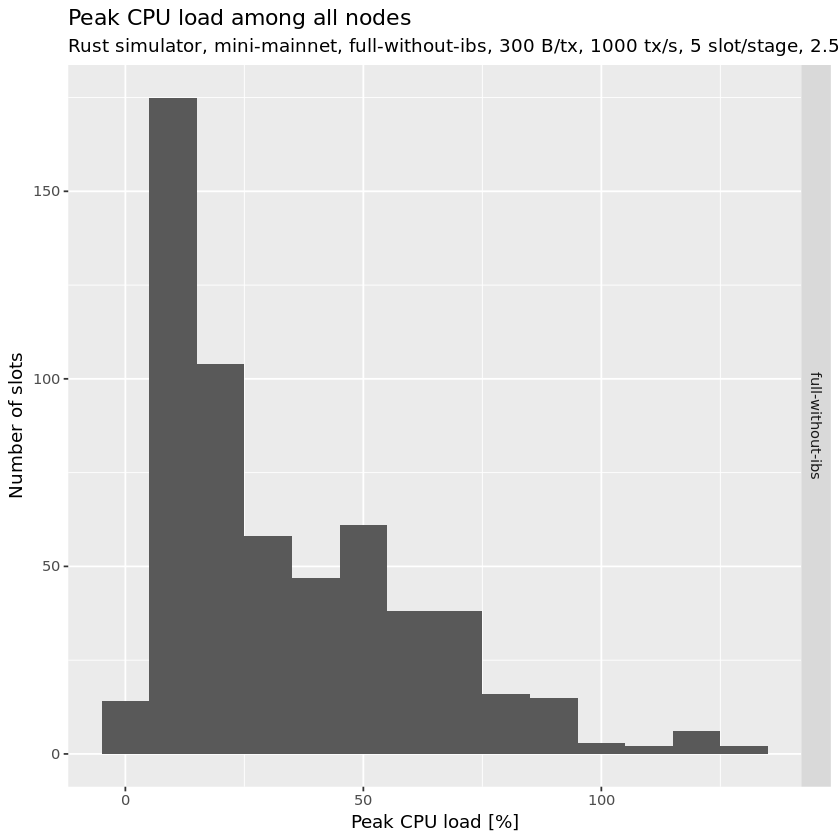

In [65]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/quick/cpu-peak-histogram.png")
)

##### Time series

In [66]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*mean(`Duration [s]`)),
            by=.(`Simulator`, `Variant`, `Slot`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Variant` ~ ., scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

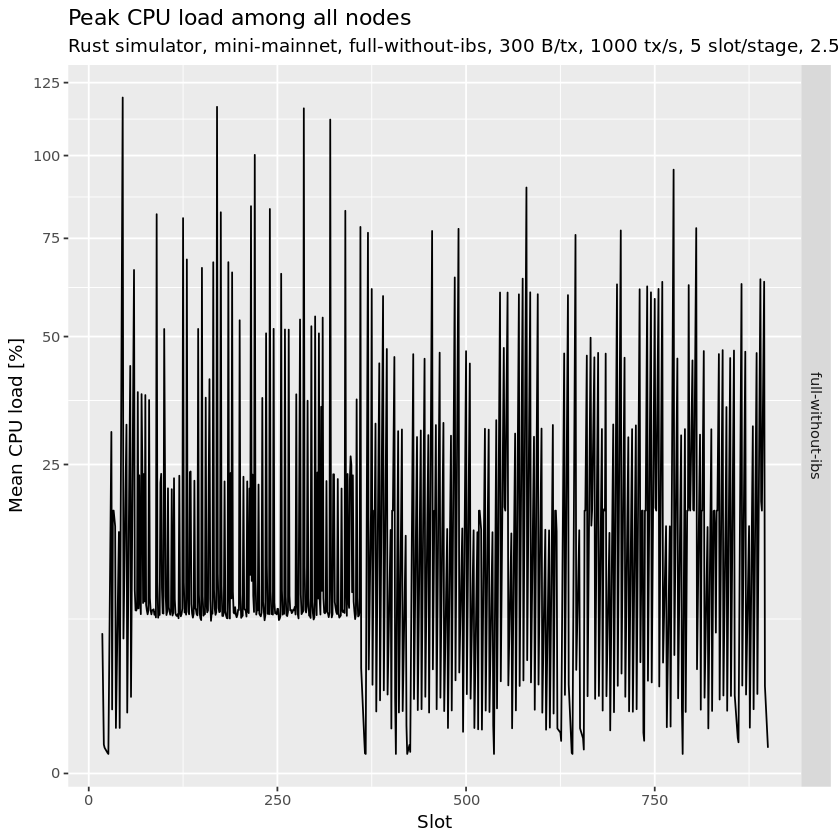

In [67]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/quick/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [68]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Simulator`, `Variant`, `Task`)
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Variant` ~ ., scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

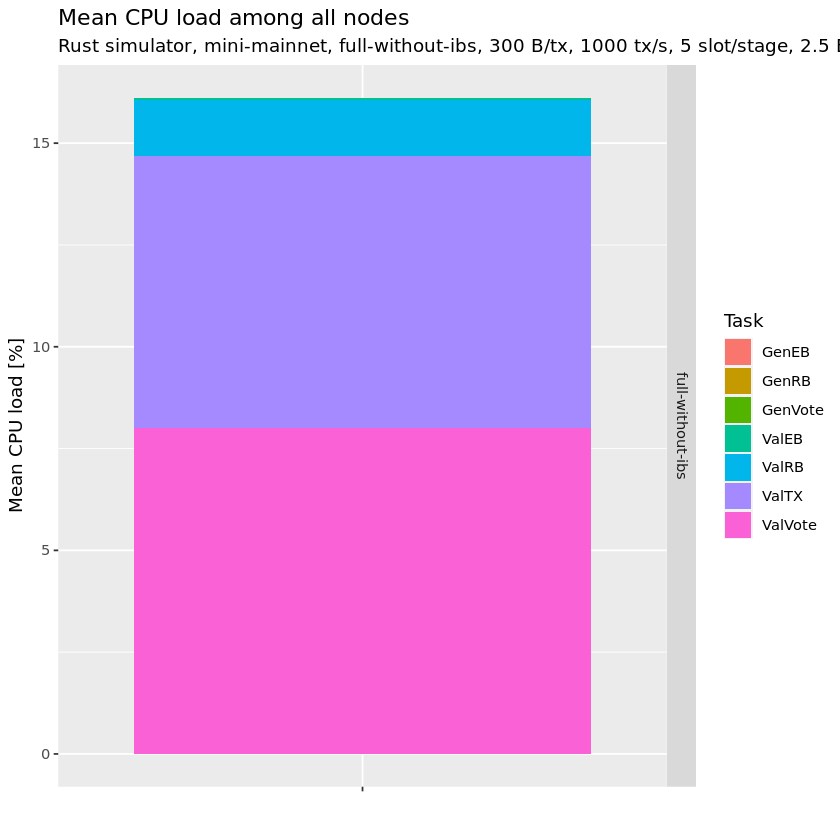

In [69]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/quick/cpu-mean-histogram.png")
)

##### Time series

In [70]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Simulator`, `Variant`, `Slot`, `Task`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Variant` ~ ., scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

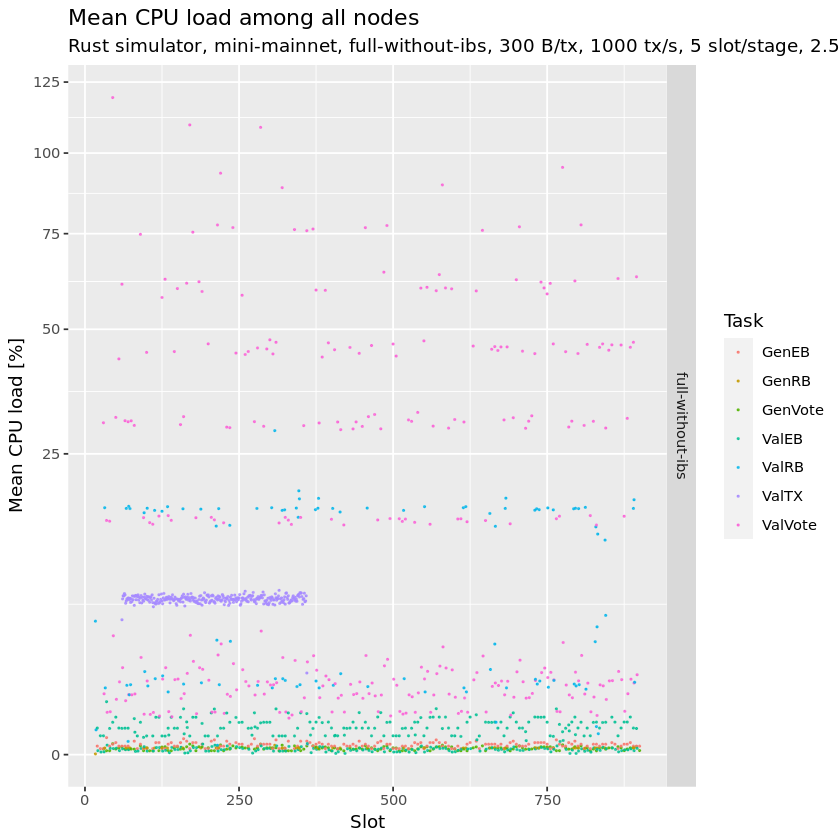

In [71]:
meanCpuTimeseries(
    cpus, 
    nodeCount, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/quick/cpu-mean-timeseries.png")
)

#### Release memory

In [72]:
rm(cpus, cpusNode)